# Working with Large Datasets
### Getting started
All exercises rely on chainladder v0.7.5 and later. There have also been breaking changes with pandas 1.0 and if you are using an earlier version, date slicing may behave differently.

In [1]:
# Black linter, optional
%load_ext lab_black

import pandas as pd
import numpy as np
import chainladder as cl

print("pandas: " + pd.__version__)
print("numpy: " + np.__version__)
print("chainladder: " + cl.__version__)

pandas: 1.3.4
numpy: 1.21.2
chainladder: 0.8.10


### Sparse triangles
By default, the chainladder `Triangle` is a wrapper around a numpy array.  Numpy is optimized for high performance and this allows chainladder to achieve decent compute speeds.  Despite being fast, numpy can become memory inefficient with triangle data because triangles are inherently sparse.

The lower half of a an incomplete triangle is generally blank and that means about 50% of an array size is wasted on empty space.  As we include granular index and column values in our `Triangle`, the sparsity of the triangle increases further consuming RAM unnecessarily.  Chainladder automatically eliminates this extraneous consumption of memory by resorting to a sparse array representation when the Triangle becomes sufficiently large.

Let's load the 'prism' dataset and include each claim number in the index of the Triangle. The dataset is claim level and includes over 130,000 triangles.

In [2]:
prism = cl.load_sample("prism")
prism

,Triangle Summary
Valuation:,2017-12
Grain:,OMDM
Shape:,"(34244, 4, 120, 120)"
Index:,"[ClaimNo, Line, Type, ClaimLiability, Limit, Deductible]"
Columns:,"[reportedCount, closedPaidCount, Paid, Incurred]"


Let's also look at the array representation of the Triangle and notice how it is no longer a numpy array, but instead a sparse array.

In [3]:
prism.values

Format,coo
Data Type,float64
Shape,"(34244, 4, 120, 120)"
nnz,121178
Density,6.143513381095148e-05
Read-only,True
Size,4.6M
Storage ratio,0.0


The sparse array consumes about 4.6Mb of memory. We can also see its density is very low, this is because individual claims will at most exist in only one origin period.  Let's approximate the size of this Triangle assuming we used a dense array representation.  Approximation can be done by assuming 8 bytes (for float64) of memory are used for each cell in the array.

In [4]:
print("Dense array size:", np.prod(prism.shape) / 1e9 * 8, "GB")
print("Sparse array size:", prism.values.nbytes / 1e6, "MB")
print(
    "Dense array is",
    round((np.prod(prism.shape) / 1e6 * 8) / (prism.values.nbytes / 1e6), 1),
    "times larger !!!",
)

Dense array size: 15.7796352 GB
Sparse array size: 4.84712 MB
Dense array is 3255.5 times larger !!!


### Incremental vs Cumulative Triangles
Cumulative triangles are naturally denser than those stored in an incremental fashion.  While almost all actuarial techniques rely on cumulative triangles, it may be worthwhile to maintain and manipulate triangles as incremental triangles until you are ready to apply a model.

Our incremental triangle is under 5MB, but when we convert to a cumulative triangle it becomes an astonishingly large 219MB and this is despite still maintaining a sparsity of under 0.3%!

In [5]:
prism = prism.incr_to_cum()
prism.values

Format,coo
Data Type,float64
Shape,"(34244, 4, 120, 120)"
nnz,5750047
Density,0.00291517360299939
Read-only,True
Size,219.3M
Storage ratio,0.0


### Claim level data
The sparse representation of triangles allows for substantially more data to be pushed through chainladder.  This gives us some nice capabilities that we would not otherwise be able to do with aggregate data.

For example, we can now drill into the individual claim makeup of any cell in our Triangle.  Let's look at January 2017 claim details at age 12.

In [6]:
claims = prism[prism.origin == "2017-01"][prism.development == 12].to_frame()
claims[abs(claims).sum(axis="columns") != 0].reset_index()

,ClaimNo,Line,Type,ClaimLiability,Limit,Deductible,reportedCount,closedPaidCount,Paid,Incurred
0,38339,Auto,PD,False,8000.0,1000,1.0,0.0,0.000000,0.000000
1,38436,Auto,PD,True,15000.0,1000,1.0,1.0,8337.875863,8337.875863
2,38142,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
3,38195,Auto,PD,True,20000.0,1000,1.0,1.0,19000.000000,19000.000000
4,38158,Auto,PD,True,20000.0,1000,1.0,1.0,10686.229420,10686.229420
...,...,...,...,...,...,...,...,...,...,...
155,38393,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
156,38396,Auto,PD,True,8000.0,1000,1.0,1.0,7000.000000,7000.000000
157,38455,Auto,PD,True,20000.0,1000,1.0,1.0,9927.351224,9927.351224
158,38457,Auto,PD,True,15000.0,1000,1.0,1.0,7874.879070,7874.879070


We can also examine the data as the usual aggregate Triangle.

<AxesSubplot:title={'center':'Prism Paid'}>

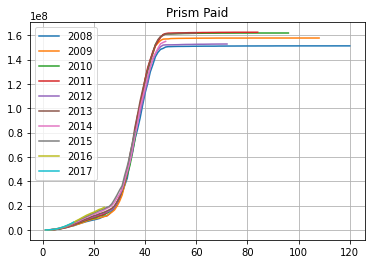

In [7]:
prism["Paid"].sum().grain("OYDM").T.plot(title="Prism Paid", grid=True)

With claim level data, we can set a claim large loss cap or create an excess Triangle on the fly.

In [ ]:
prism["Capped 100k Paid"] = cl.minimum(prism["Paid"], 100000)
prism["Excess 100k Paid"] = prism["Paid"] - prism["Capped 100k Paid"]
prism["Excess 100k Paid"].sum().grain("OYDM").T.plot(title="Prism Paid", grid=True)

Let's see how we can use the API to create claim-level IBNR estimates.  When using aggregate actuarial techniques, it really makes sense to perform the model fitting at an aggregate level.  

We use aggregate data to fit the model to generate reasonable development patterns.

In [ ]:
agg_data = prism.sum()[["Paid", "reportedCount"]]
model_cl = cl.Chainladder().fit(agg_data)

With the fitted model, we are not limited to predicting ultimates at the aggregate grain.  Let's predict chainladder ultimates at a claim level.

In [ ]:
cl_ults = model_cl.predict(prism[["Paid", "reportedCount"]]).ultimate_
cl_ults

We could stop here, but let's try a BornhuetterFerguson method as well.  We will infer an apriori severity from our chainladder model above.

40K seems a reasonable apriori (at least for the last two years).

In [ ]:
(model_cl.ultimate_["Paid"] / model_cl.ultimate_["reportedCount"]).plot(
    grid=True, legend=False, title="Ultimate Severity"
)

Now, let's fit an aggregate BornhuetterFerguson model.  Like the chainladder example, we fit the model in aggregate (summing all claims) to create a stable model from which we can generate granular predictions.  We will use our Chainladder ultimate claim counts as our `sample_weight` (exposure) for the BornhuetterFerguson method.

In [ ]:
paid_bf = cl.BornhuetterFerguson(apriori=40000).fit(
    X=prism["Paid"].sum().incr_to_cum(), sample_weight=cl_ults["reportedCount"].sum()
)

In [ ]:
paid_bf.ultimate_.grain("OYDM").plot(
    kind="bar",
    grid=True,
    legend=False,
    title="BornhuetterFerguson Ultimates (Aggregate)",
)

We can now create claim-level BornhuetterFerguson predictions using our claim-level Triangle.  Ideally, the results should tie to the aggregate results.

In [ ]:
bf_ults = paid_bf.predict(
    prism["Paid"].incr_to_cum(), sample_weight=cl_ults["reportedCount"]
).ultimate_

bf_ults.sum().grain("OYDM").plot(
    kind="bar",
    grid=True,
    legend=False,
    title="BornhuetterFerguson Ultimates (Claim Level)",
)

Let's do a 50/50 blend of the Chainladder and BornhuetterFerguson ultimates at a claim level 

In [ ]:
selected = (
    ((cl_ults["Paid"] + bf_ults["Paid"]) / 2)
    .sum("origin")
    .to_frame()
    .rename("Selected Ultimate")
)
selected.head()

With individual claim ultimates, let's just take a quick peek at the distribution of our ultimate claims by claim size.

In [ ]:
selected.plot(kind="hist", bins=500, xlim=(0, 350000), grid=True)

### Finer controls
Whether chainladder uses a dense or sparse representation shouldn't matter too much to you.  Behind the scenes, chainladder will convert between sparse and dense arrays for you and your code should just work.  However, if you'd like to force the package to use specific array types, you can disable the automatic sparse/dense conversions globally as follows:
```python
cl.auto_sparse(False)
```
The `cupy` backend currently does not support a sparse representation using the GPU can only.  In these cases, the `auto_sparse` property will be ignored.

You can also convert any Triangle array representation manually calling the `set_backend` method.
```python
triangle.set_backend('sparse')
triangle.set_backend('numpy')
triangle.set_backend('cupy')
```
This too can be done globally:
```python
cl.array_backend('cupy')
```


### Conclusion
* We can substantially increase the size of data that can be put into the `chainladder` package.
* Fitting a model in aggregate and predicting at a more granular level implicitly allows for IBNR allocation to the lowest grain possible.  This can be very useful to allow for reaggregation of IBNR across various cuts of your data and/or storing in a database.